# Assignment — Compartmental Epidemic Models

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from zlib import adler32
from scipy.optimize import minimize
import math

### Task 1. Euler method for ODE (1 point)

Euler method is a simple numerical procedure for solving ordinary differential equations (ODEs) with a given initial values.  For example, if we want to solve an equation

$$dx/dt = \sin(x)$$

with initial value $x = x_0$, we can subtitute $dx = \Delta x = x_{i+1} - x_{i}$ and $dt = \Delta t$, therefore we obtain

$$\frac{x_{i+1} - x_i}{\Delta t} = \sin(x)$$ 
$$x_{i+1} = x_i + \sin(x)\Delta t$$

Let $\Delta t = 0.1$, and then we can solve the equation using this iterative form as follows

In [2]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

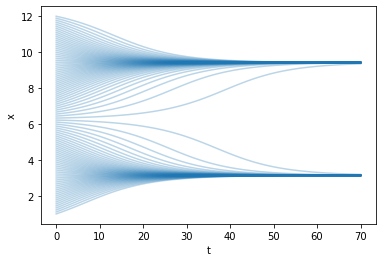

In [3]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Assume that we want to solve the famous chaotic Lorenz System:

$$
\begin{cases}
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z) - y\\
\frac{dz}{dt} = xy - \beta z\\
\end{cases}
$$

with parameters $\rho = 28$, $\sigma = 10$, $\beta = 8/3$ and initial values $x = y = z = 10$.

Write a function `lorenz` that takes initial values, parameters, time increment `dt`, number of iterations `k` and returns np.array with solution of the form `[[x0, y0, z0], [x1, y1, z1], ...]` so that number of rows is `k+1`.

In [6]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    res = np.zeros((k+1,3))
    res[0][0] = x0
    res[0][1] = y0
    res[0][2] = z0

    for i in range(1, k):
        x = res[i-1][0]
        y = res[i-1][1]
        z = res[i-1][2]
        res[i][0] = x + (sigma*(y-x))*dt
        res[i][1] = y + (x*(rho-z)-y)*dt
        res[i][2] = z + (x*y-beta*z)*dt

    return res

In [7]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

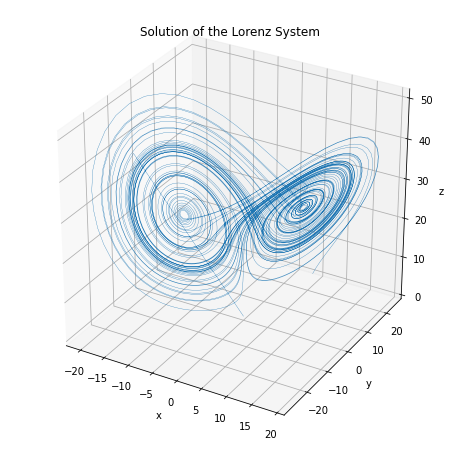

In [8]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### Task 2. SI model (1 point)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [11]:
def si_epidemic(total, I0, beta, dt, k):
    res=np.zeros((k+1,2))
    S0=total-I0
    res[0][0]=S0
    res[0][1]=I0

    for i in range(1,k+1):
        S=res[i-1][0]
        I=res[i-1][1]
        res[i][1]=I+beta*S/total*I*dt
        res[i][0]=total-res[i][1]

    return res

In [12]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

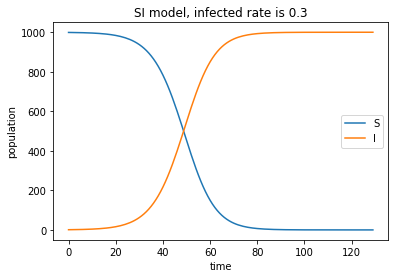

In [13]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

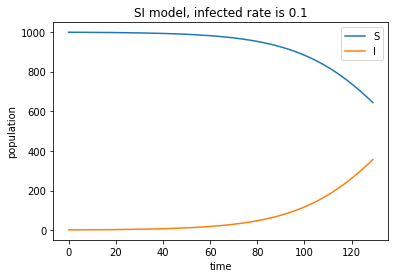

In [14]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. Numerical vs analytical solution of SI model (1 point)

The SI model has an analytical solution

$$i(t) = \frac{i_0}{i_0 + (1 - i_0)e^{-\beta t}}$$

where $i(t)$ is the share of infected people at time moment $t$. Let us compare the analytical solution and Euler method.

Write a function `si_epidemic_analytically` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns np.array `[[S0, I0], [S1, I1], ...]` is an analytical solution so that number of rows is `k+1`.

In [29]:
def si_epidemic_analytically(total, I0, beta, dt, k):
    S0 = total - I0
    res = [[S0, I0]]
    for i in range(k):
        i0 = I0/total
        i_curr = i0/(i0+(1-i0)*math.exp(-beta*(dt*(i+1))))
        I = i_curr*total
        S = total - I
        res.append([S,I])
    return np.array(res)

In [30]:
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert analytical_solution.shape == (130, 2)
assert np.all(analytical_solution[0] == [999, 1])
assert np.all(analytical_solution[10].round(2) == [995.53, 4.47])
assert np.all(analytical_solution[-1].round(2) == [0, 1000])
assert adler32(str(analytical_solution[100].round(2)[0]).encode()) == 31785155

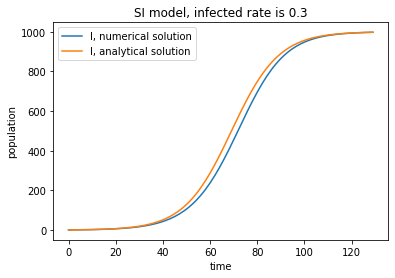

In [31]:
solution = si_epidemic(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
plt.plot(solution[:, 1], label='I, numerical solution')
plt.plot(analytical_solution[:, 1], label='I, analytical solution')
plt.legend()
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 4. SIS model (2 points)

Next, consider SIS model. S — susceptible, I — infectious. At the next time moment, some susceptible people become infected with infection rate $\beta$ and some infected people become susceptible with recovery rate $\gamma$. The model is defined as follows:

Dynamic form

$$S \underset{\beta S I}{\to} I \underset{\gamma I}{\to} S$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I - \gamma I$$

$$S + I = N$$

where $N$ is the total population. 

Write a function `sis_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, recovery rate `gamma`, time increment `dt`, number of iterations `k` and returns a solution of the form of a np.array

`[[S0, I0], [S1, I1], ...]`

so that number of rows is `k+1`.

In [32]:
def sis_epidemic(total, I0, beta, gamma, dt, k):
    S0 = total - I0
    res = [[S0, I0]]
    I = I0
    S = S0
    for i in range(k):
        I = I+(beta*S/total*I-gamma*I)*dt
        S = total - I
        res.append([S,I])
    return np.array(res)

In [33]:
total = 1000
beta, gamma = 0.3, 0.1
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=600-1)
assert solution.shape == (600, 2)
assert np.all(solution[0] == [900, 100])
assert np.all(solution[10].round(2) == [861.63, 138.37])
assert solution[-1, 1].round(2) == round((1 - gamma / beta) * total, 2)
assert adler32(str(solution[100].round(2)[0]).encode()) == 72548667

Here is the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $i(+\infty) \to (1 - \gamma / \beta)$
* If $R_0 < 1$: Disease-free State, $i(+\infty) \to 0$

where $i(t)$ is the share of infected people at the time moment $t$.

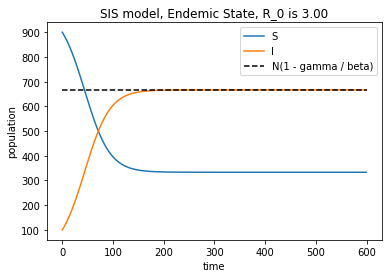

In [34]:
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.plot([0, 600], [limit, limit], '--', c='black')
plt.legend(['S', 'I', 'N(1 - gamma / beta)'])
plt.title('SIS model, Endemic State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

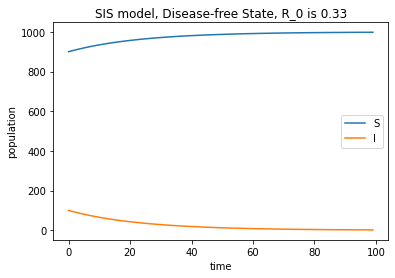

In [35]:
beta, gamma = 0.1, 0.3
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=100-1)
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.legend(['S', 'I'])
plt.title('SIS model, Disease-free State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 5. SIR model (1 point)

The next model is SIR. S — susceptible, I — infectious, R — recovered people. Initialy we only have a few infected persons and others are susceptible. Then some susceptible people become infected with infection rate $\beta$ and some infected people recover with recovery rate $\gamma$. There is no chance to infect after recovering. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R$$

Equation form (in proportions of the population)

$$\begin{cases}
ds/dt = -\beta si\\
di/dt = \beta si - \gamma i\\
dr/dt = \gamma i\\
s+i+r = 1
\end{cases}$$

Write a function `sir_epidemic` that takes an initial proportion `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [251]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    result = [[s0, i0, r0]]
    for j in range(k):
      s = result[j][0] - dt*beta*result[j][0]*result[j][1]
      i = result[j][1] + dt*(beta*result[j][0]*result[j][1] - gamma*result[j][1])
      r = result[j][2] + dt*gamma*result[j][1]
      sum = s + i + r
      s, i, r = s/sum, i/sum, r/sum
      result.append([s,i,r])
    return np.array(result)

In [175]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Here is also the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $r(+\infty) \to 1$
* If $R_0 < 1$: Disease-free State, $r(+\infty) \to \text{const}$

where $r(t)$ is the share of recovered people at the time moment $t$.

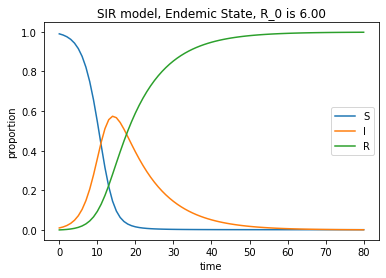

In [19]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

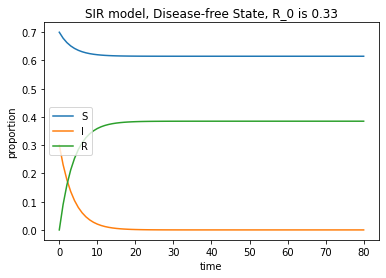

In [20]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

### Task 6. SIRS model (2 points)

The next model is SIRS, that is the same as SIR with an exception that recovered people lose their immunity with rate $\delta$. The dynamic form is

$$S \underset{\beta SI}{\to} I \underset{\gamma I}{\to} R \underset{\delta R}{\to} S$$

Try to find an equation form using a dynamic form and implement this model.

Write a function `sirs_epidemic` that takes an initial proportion of `s0`, `i0`, `r0`, infection rate `beta`, recovery rate `gamma`, loss of immunity rate `delta`, a number of steps `k` and time increment `dt`. The function returns np.array of shape `(k+1, 3)` with `s`, `i`, `r` proportion in each step. The first row contains an initial proportion.

In [36]:
def sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt):
    res = [[s0, i0, r0]]
    s=s0
    i=i0
    r=r0
    for _ in range(k):
        s_new = s-(beta*s*i)*dt + (delta*r)*dt
        i_new = i+(beta*s*i-gamma*i)*dt
        r_new = r+(gamma*i)*dt - (delta*r)*dt

        res.append([s_new, i_new, r_new])
        s=s_new
        i=i_new
        r=r_new
    return np.array(res)

In [37]:
s0, i0, r0 = 0.9, 0.1, 0
beta, gamma, delta = 0.7, 0.3, 0.03
dt = 1
epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, 200, dt)
assert epidemic.shape == (201, 3)
assert np.all(epidemic[0] == [0.9, 0.1, 0])
assert np.all(epidemic[5].round(2) == [0.48, 0.27, 0.25])
assert np.all(epidemic[80].round(2) == [0.39, 0.05, 0.56])
assert np.all(epidemic[200].round(2) == [0.43, 0.05, 0.52])
assert adler32(str(epidemic[10].round(2).max()).encode()) == 32506060

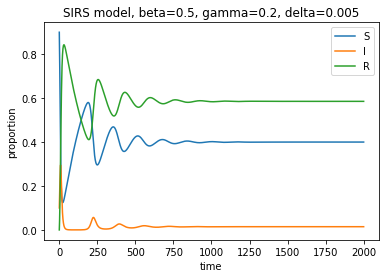

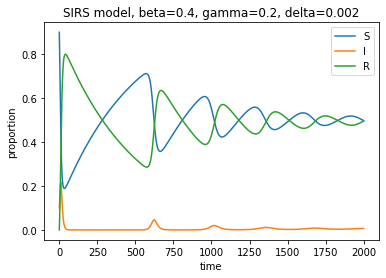

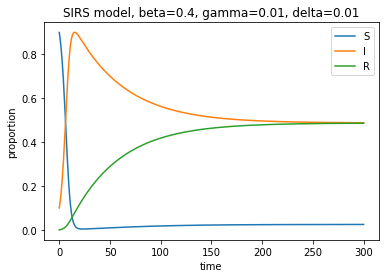

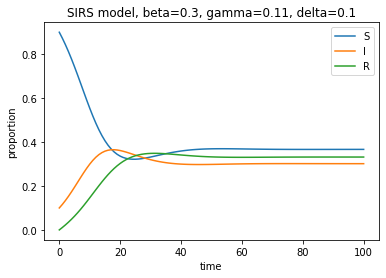

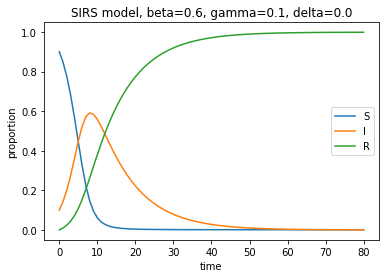

In [38]:
cases = [[0.5, 0.20, 0.005, 2000],
         [0.4, 0.20, 0.002, 2000],
         [0.4, 0.01, 0.010, 300 ],
         [0.3, 0.11, 0.100, 100 ],
         [0.6, 0.10, 0.000, 80  ]]
for beta, gamma, delta, k in cases:
    epidemic = sirs_epidemic(s0, i0, r0, beta, gamma, delta, k, dt)
    plt.plot(epidemic)
    plt.legend(['S', 'I', 'R'])
    plt.xlabel('time')
    plt.ylabel('proportion')
    plt.title('SIRS model, beta={}, gamma={}, delta={}'.format(beta, gamma, delta, k))
    plt.show()

### Task 7. Fitting SIR model (2 points)

In this task we will numerically estimate parameters of SIR model.

In the previous task you already define `sir_epidemic` function that generate trajectories according to the SIR model.

In the current task we will define two functions: `sir_error` and `fit_sir`.
The first one estimates the RMSE error between real data and SIR model (here, we only try to predict infection rates). The second one minimize that error and return best parameters `beta` and `gamma` for SIR model via `scipy.optimize.minimize`.

In the function `initial_conditions` is the list with distribution of susceptible, infectious and recovered rates. `beta` and `gamma` are the parameters of SIR model and `data` is the observations of infected rate increments.

`sir_error` should return RMSE error between `dI`.

`fit_sir` should return `np.array` with estimates of `beta` and `gamma`

In [246]:
def sir_error(beta, gamma, initial_conditions, data):
    model_data = sir_epidemic(initial_conditions[0], initial_conditions[1], initial_conditions[2], beta, gamma, 100, 1)
    model_I = model_data[:,1]
    dI = np.diff(model_I)
    rmse = np.sqrt(np.sum((data-dI)**2))
    return rmse

In [252]:
from scipy.optimize import minimize
def fit_sir(initial_conditions, data, initial_params):
    f = lambda x: sir_error(x[0],x[1],initial_conditions, data)
    res = minimize(f, x0 = initial_params)
    print(res.x)
    return res.x

In [253]:
assert round(sir_error(0.01, 0.05, [0.99, 0.01, 0], np.diff(np.arange(101) / 1010)), 4) == 0.0109
beta, gamma = fit_sir([0.99, 0.01, 0], np.diff(np.arange(101) / 1010), (0.01, 0.01))
assert round(beta, 4) == 0.0831
assert round(gamma, 4) == 0.0501

[0.08314049 0.05012869]


Now let us generate trajectories with noise and estimate parameters based on it

In [254]:
data = sir_epidemic(0.99, 0.01, 0, 0.05, 0.02, 1000, 1)
np.random.seed(0)
noise = (np.random.random(size=(data.shape[0], 2)) - 0.5) / 50
noise = np.hstack([-noise.sum(1, keepdims=True), noise])
data += noise
diff = np.diff(data, axis=0)

beta, gamma = fit_sir([0.99, 0.01, 0], diff[:, 1], (0.01, 0.01))

assert round(beta, 2) == 0.05
assert round(gamma, 2) == 0.02

[0.04998719 0.02000606]


Text(0.5, 1.0, 'SIR model')

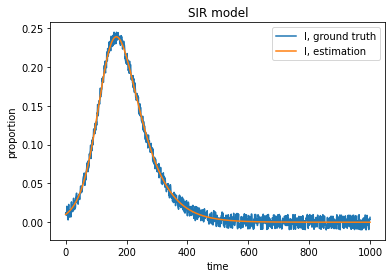

In [255]:
data_est = sir_epidemic(0.99, 0.01, 0, beta, gamma, 1000, 1)

plt.plot(data[:, 1], label="I, ground truth")
plt.plot(data_est[:, 1], label="I, estimation")
plt.xlabel("time")
plt.ylabel("proportion")
plt.legend()
plt.title("SIR model")